# EEG Signal Quality Benchmark Notebook

This notebook automatically assesses EEG signal quality using MNE-Python.
It calculates three key metrics based on the MNE sample dataset:
1. Signal-to-Noise Ratio (SNR)
2. Common Mode Rejection Ratio (CMRR) Proxy (Line Noise Power)
3. Alpha Power Ratio (Eyes Closed vs. Eyes Open proxy)

The calculations aim to follow principles from Mike Cohen's "Analyzing Neural Time Series Data".

## 1. Setup and Dependencies

Import necessary libraries and define the configuration dictionary.

In [29]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from mne.datasets import sample
import traceback # Added for better error reporting
import json # For printing results

In [30]:
# Configuration Dictionary
config = {
    # Data Loading
    'data_path': sample.data_path(),
    'raw_fname_relative': os.path.join('MEG', 'sample', 'sample_audvis_raw.fif'),
    'channels_to_analyze': ['EEG 001', 'EEG 002', 'EEG 058', 'EEG 059', 'EEG 060'], # Example frontal and occipital channels
    # Preprocessing
    'filter_bp_low': 1.0,  # Hz
    'filter_bp_high': 45.0, # Hz
    'line_noise_freq': 60.0, # Hz (for MNE sample dataset)
    'apply_average_reference': True,
    # SNR Calculation
    'snr_signal_band': [8.0, 13.0], # Hz (Alpha band)
    'snr_noise_bands': [[4.0, 7.0], [14.0, 30.0]], # Hz (Theta and Beta bands as noise estimate)
    'psd_method': 'welch',
    'psd_n_fft': 1024, # Samples (ИЗМЕНЕНО!)
    'psd_n_overlap': 512, # Samples (ИЗМЕНЕНО!)
    'psd_fmin': 1.0, # Hz
    'psd_fmax': 50.0, # Hz (Max freq for general PSD)
    'psd_fmax_cmrr': 70.0, # Hz (Max freq for CMRR PSD to include 60Hz)
    # CMRR Proxy Calculation
    'cmrr_noise_bandwidth': 1.0, # Hz (bandwidth around line noise freq)
    # Alpha Power Ratio Calculation
    'alpha_band': [8.0, 13.0], # Hz
    # Note: Sample dataset lacks clear eyes open/closed. Using time segments as proxy.
    'alpha_test_conditions': {
        'closed_proxy': {'tmin': 0.0, 'tmax': 10.0}, # First 10s as proxy for eyes closed/rest
        'open_proxy': {'tmin': 60.0, 'tmax': 70.0}   # Later 10s during task as proxy for eyes open/active
    },
    'alpha_epoch_duration': 2.0, # Duration for fixed-length events
    # Noise Addition
    'noise_level_factor': 10.0 # Factor relative to signal std dev to scale noise (Increased significantly)
}

# Construct the full path after getting the data_path
config['raw_fname'] = os.path.join(config['data_path'], config['raw_fname_relative'])

print(f"Using MNE sample data from: {config['data_path']}")
print(f"Raw file path: {config['raw_fname']}")

Using MNE sample data from: C:\Users\fedor\mne_data\MNE-sample-data
Raw file path: C:\Users\fedor\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif


## 2. Load and Basic Data Preparation

Load the MNE sample dataset (`sample_audvis_raw.fif`), select specific EEG channels, and set their type.
A copy of the raw data is created *before* notch filtering for the CMRR proxy calculation.

In [32]:
# Load the raw data
raw_orig = mne.io.read_raw_fif(config['raw_fname'], preload=True)

# Select specific EEG channels
raw_orig.pick_channels(config['channels_to_analyze'])

# Set channel types to EEG (important for some MNE functions)
# Create a mapping for the selected channels
channel_mapping = {ch_name: 'eeg' for ch_name in raw_orig.ch_names}
raw_orig.set_channel_types(channel_mapping)

# Make a copy for CMRR proxy calculation *before* notch filtering
raw_for_cmrr_orig = raw_orig.copy()

print("\nOriginal raw data loaded and channels selected:")
print(raw_orig.info)

Opening raw data file C:\Users\fedor\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Original raw data loaded and channels selected:
<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: EEG 001, EEG 002, EEG 058, EEG 059, EEG 060
 chs: 5 EEG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpa

## 3. Preprocessing

Apply band-pass filtering, notch filtering (to the main `raw` object only), and optionally, average referencing.

In [33]:
# --- Preprocess the ORIGINAL signal --- 
raw = raw_orig.copy() # Work on a copy for preprocessing
raw_for_cmrr = raw_for_cmrr_orig.copy()

# Apply band-pass filter to both raw objects
print(f"\nApplying band-pass filter ({config['filter_bp_low']}-{config['filter_bp_high']} Hz) to ORIGINAL signal...")
raw.filter(l_freq=config['filter_bp_low'], h_freq=config['filter_bp_high'],
           fir_design='firwin', verbose=False)
raw_for_cmrr.filter(l_freq=config['filter_bp_low'], h_freq=config['filter_bp_high'],
                    fir_design='firwin', verbose=False)
print("Band-pass filtering applied to ORIGINAL signal.")

# Apply notch filter only to the main raw object
print(f"\nApplying notch filter ({config['line_noise_freq']} Hz) to main ORIGINAL raw object...")
raw.notch_filter(freqs=config['line_noise_freq'], fir_design='firwin', verbose=False)
print("Notch filtering applied to main ORIGINAL raw object.")

# Apply average reference (optional but recommended)
if config['apply_average_reference']:
    print("\nApplying average reference to ORIGINAL signal...")
    raw.set_eeg_reference('average', projection=True, verbose=False)
    raw.apply_proj(verbose=False)
    # Apply to the CMRR copy as well if desired, though CMRR is often assessed pre-reference
    # raw_for_cmrr.set_eeg_reference('average', projection=True, verbose=False)
    # raw_for_cmrr.apply_proj(verbose=False)
    print("Average reference applied to ORIGINAL signal.")
else:
    print("\nSkipping average reference for ORIGINAL signal.")


Applying band-pass filter (1.0-45.0 Hz) to ORIGINAL signal...
Band-pass filtering applied to ORIGINAL signal.

Applying notch filter (60.0 Hz) to main ORIGINAL raw object...
Notch filtering applied to main ORIGINAL raw object.

Applying average reference to ORIGINAL signal...
Average reference applied to ORIGINAL signal.


## 4. Calculate Quality Metrics for ORIGINAL Signal

Now, calculate the three quality metrics: SNR, CMRR Proxy, and Alpha Power Ratio for the original, preprocessed signal.

### 4.1. SNR (Original Signal)

Calculated using Welch's PSD on the fully preprocessed data. SNR is defined as the ratio of power in the signal band (alpha) to the average power in surrounding noise bands (theta, beta).

In [34]:
print("\nCalculating SNR for ORIGINAL signal...")
# Calculate PSD using Welch's method on the fully processed data
spectrum = raw.compute_psd(
    method=config['psd_method'],
    fmin=config['psd_fmin'],
    fmax=config['psd_fmax'], # Use general fmax here
    n_fft=config['psd_n_fft'],
    n_overlap=config['psd_n_overlap'],
    picks=config['channels_to_analyze'],
    verbose=False
)
psds, freqs = spectrum.get_data(return_freqs=True) # Shape: (n_channels, n_freqs)

# Find frequency indices for signal and noise bands
signal_band = config['snr_signal_band']
noise_bands = config['snr_noise_bands']

freq_res = freqs[1] - freqs[0] # Frequency resolution

# Signal band indices
sig_idx = np.where((freqs >= signal_band[0]) & (freqs <= signal_band[1]))[0]

# Noise band indices
noise_idx = []
for band in noise_bands:
    noise_idx.extend(np.where((freqs >= band[0]) & (freqs <= band[1]))[0])
noise_idx = np.array(sorted(list(set(noise_idx)))) # Unique sorted indices

# Calculate power (approximated by summing PSD values in the band)
# Simple average power density:
signal_power_density = np.mean(psds[:, sig_idx], axis=1) # Average PSD value in signal band per channel
noise_power_density = np.mean(psds[:, noise_idx], axis=1) # Average PSD value in noise bands per channel

# Avoid division by zero or log(0)
epsilon = 1e-15
signal_power_density = np.maximum(signal_power_density, epsilon)
noise_power_density = np.maximum(noise_power_density, epsilon)

# Calculate SNR in dB
snr_db_per_channel = 10 * np.log10(signal_power_density / noise_power_density)

# Average SNR across channels
average_snr_db_orig = np.mean(snr_db_per_channel)

print(f"Average SNR across channels (Original): {average_snr_db_orig:.2f} dB")


Calculating SNR for ORIGINAL signal...
Average SNR across channels (Original): 3.77 dB


### 4.2. CMRR Proxy (Original Signal)

Calculated using Welch's PSD on the data *before* notch filtering (`raw_for_cmrr`). It measures the power specifically around the line noise frequency. Lower values indicate better rejection of common-mode line noise.

In [35]:
print("\nCalculating CMRR Proxy (Line Noise Power) for ORIGINAL signal...")
# Calculate PSD using Welch's method on the data *before* notch filter
spectrum_cmrr = raw_for_cmrr.compute_psd(
    method=config['psd_method'],
    fmin=config['psd_fmin'],
    fmax=config['psd_fmax_cmrr'], # Use specific fmax for CMRR
    n_fft=config['psd_n_fft'],
    n_overlap=config['psd_n_overlap'],
    picks=config['channels_to_analyze'],
    verbose=False
)
psds_cmrr, freqs_cmrr = spectrum_cmrr.get_data(return_freqs=True)

# Find frequency indices around the line noise frequency
noise_freq = config['line_noise_freq']
noise_bw = config['cmrr_noise_bandwidth']
line_noise_idx = np.where((freqs_cmrr >= noise_freq - noise_bw / 2) &
                          (freqs_cmrr <= noise_freq + noise_bw / 2))[0]

if len(line_noise_idx) == 0:
    print(f"Warning: No frequency bins found within {noise_bw} Hz of {noise_freq} Hz. Check PSD settings (sfreq, n_fft, fmax_cmrr).")
    line_noise_power_per_channel = np.full(psds_cmrr.shape[0], np.nan)
else:
    # Calculate average power density in the line noise band
    line_noise_power_per_channel = np.mean(psds_cmrr[:, line_noise_idx], axis=1)

# Average across channels
average_line_noise_power_orig = np.nanmean(line_noise_power_per_channel) # Use nanmean in case of issues

print(f"Average Line Noise Power (CMRR Proxy) across channels (Original): {average_line_noise_power_orig:.2e} (uV^2/Hz)")


Calculating CMRR Proxy (Line Noise Power) for ORIGINAL signal...
Average Line Noise Power (CMRR Proxy) across channels (Original): 7.39e-17 (uV^2/Hz)


### 4.3. Alpha Power Ratio (Original Signal)

Compares the power in the alpha band between two conditions, typically "eyes closed" vs. "eyes open".
**Note:** The MNE sample dataset lacks explicit markers for these states. We use the first 10 seconds as a proxy for "eyes closed/rest" and seconds 60-70 as a proxy for "eyes open/active". This metric's interpretation is limited by this dataset.

In [36]:
print("\nCalculating Alpha Power Ratio for ORIGINAL signal...")

alpha_results_orig = {'ratio_per_channel': [], 'average_ratio': np.nan}
epsilon = 1e-15 # Define epsilon here as well

try:
    # --- Create Epochs for the two proxy conditions using make_fixed_length_events ---
    epochs_list = []
    conditions = ['closed_proxy', 'open_proxy']
    event_id_map = {'closed_proxy': 1, 'open_proxy': 2}

    for condition in conditions:
        tmin = config['alpha_test_conditions'][condition]['tmin']
        tmax = config['alpha_test_conditions'][condition]['tmax']

        # Crop the raw data to the relevant time segment first
        raw_cropped = raw.copy().crop(tmin=tmin, tmax=tmax, include_tmax=False)

        # Make events for this cropped segment
        events = mne.make_fixed_length_events(raw_cropped,
                                              id=event_id_map[condition],
                                              duration=config['alpha_epoch_duration'])

        if events.shape[0] == 0:
             print(f"Debug: No events generated for condition '{condition}'. Skipping epoch creation.")
             epochs = mne.EpochsArray(np.empty((0, len(config['channels_to_analyze']), 1)),
                                      mne.create_info(config['channels_to_analyze'], raw.info['sfreq'], ch_types='eeg'))
             epochs_list.append(epochs)
             continue

        # Adjust event timings for the original raw object
        events[:, 0] += raw.time_as_index(tmin)[0]

        epochs = mne.Epochs(
            raw, # Use the original, fully processed raw object
            events=events,
            event_id=event_id_map[condition],
            tmin=0,
            tmax=config['alpha_epoch_duration'],
            baseline=None, reject=None, flat=None,
            picks=config['channels_to_analyze'],
            preload=True, verbose=False
        )
        epochs_list.append(epochs)
        print(f"Created {len(epochs)} epochs for condition '{condition}' (Original)")

    if len(epochs_list) != 2:
        raise ValueError("Could not create epochs for both conditions.")
        
    epochs_closed, epochs_open = epochs_list

    # --- Calculate PSD for each condition ---
    if len(epochs_closed) == 0 or len(epochs_open) == 0:
        raise ValueError("Not enough epochs for one or both conditions.")

    spectrum_closed = epochs_closed.compute_psd(
        method=config['psd_method'], fmin=config['psd_fmin'], fmax=config['psd_fmax'],
        n_fft=config['psd_n_fft'], n_overlap=config['psd_n_overlap'],
        average='mean', picks=config['channels_to_analyze'], verbose=False
    )
    psds_closed, freqs_alpha = spectrum_closed.get_data(return_freqs=True)

    spectrum_open = epochs_open.compute_psd(
        method=config['psd_method'], fmin=config['psd_fmin'], fmax=config['psd_fmax'],
        n_fft=config['psd_n_fft'], n_overlap=config['psd_n_overlap'],
        average='mean', picks=config['channels_to_analyze'], verbose=False
    )
    psds_open, _ = spectrum_open.get_data(return_freqs=True)

    # Average PSDs across epochs if necessary (MNE might return 3D)
    if psds_closed.ndim == 3:
        psds_closed_avg = np.mean(psds_closed, axis=0)
        psds_open_avg = np.mean(psds_open, axis=0)
    else:
        psds_closed_avg = psds_closed
        psds_open_avg = psds_open

    # --- Calculate Alpha Power Ratio ---
    alpha_band = config['alpha_band']
    if psds_closed_avg.shape[1] != len(freqs_alpha):
         raise ValueError(f"Mismatch between averaged PSD frequency dimension ({psds_closed_avg.shape[1]}) and freqs_alpha length ({len(freqs_alpha)})")

    alpha_idx = np.where((freqs_alpha >= alpha_band[0]) & (freqs_alpha <= alpha_band[1]))[0]

    if len(alpha_idx) == 0:
        raise ValueError(f"No frequency bins found in alpha band {alpha_band}. Check PSD settings.")

    alpha_power_closed = np.mean(psds_closed_avg[:, alpha_idx], axis=1)
    alpha_power_open = np.mean(psds_open_avg[:, alpha_idx], axis=1)

    alpha_power_open = np.maximum(alpha_power_open, epsilon)

    alpha_ratio_per_channel = alpha_power_closed / alpha_power_open
    alpha_results_orig['ratio_per_channel'] = alpha_ratio_per_channel

    average_alpha_ratio_orig = np.mean(alpha_ratio_per_channel)
    alpha_results_orig['average_ratio'] = average_alpha_ratio_orig

    print(f"Average Alpha Power Ratio (Closed/Open Proxy) across channels (Original): {average_alpha_ratio_orig:.2f}")
    print("(Note: Ratio based on time segment proxies, not explicit events)")

except ValueError as e:
    print(f"Error calculating Alpha Power Ratio for ORIGINAL signal: {e}")
    print("Skipping Alpha Power Ratio calculation for ORIGINAL signal.")
except Exception as e:
    print(f"An unexpected error occurred during Alpha Power Ratio calculation for ORIGINAL signal:\n{traceback.format_exc()}")
    print("Skipping Alpha Power Ratio calculation for ORIGINAL signal.")


Calculating Alpha Power Ratio for ORIGINAL signal...
Created 5 epochs for condition 'closed_proxy' (Original)
Created 5 epochs for condition 'open_proxy' (Original)
Average Alpha Power Ratio (Closed/Open Proxy) across channels (Original): 0.63
(Note: Ratio based on time segment proxies, not explicit events)


## 5. Create Degraded Signal and Recalculate Metrics

Now, let's artificially degrade the signal by adding Gaussian noise and recalculate the metrics for comparison.

In [37]:
print("\n--- Degrading Signal and Recalculating Metrics ---")

# --- Create Noisy Copies ---
raw_noisy = raw.copy() # Start from the preprocessed original signal
raw_for_cmrr_noisy = raw_for_cmrr.copy() # Start from the pre-notch filtered original signal

# --- Add Gaussian Noise ---
# Calculate signal standard deviation (use the preprocessed 'raw' object)
signal_data = raw.get_data()
signal_std = np.std(signal_data)

# Calculate noise standard deviation
noise_std = signal_std * config['noise_level_factor']
print(f"Signal std dev: {signal_std:.2e}")
print(f"Adding Gaussian noise with std dev: {noise_std:.2e} ({config['noise_level_factor'] * 100}% of signal std)")

# Generate noise
noise = np.random.normal(0, noise_std, size=signal_data.shape)

# Add noise to the main preprocessed signal
raw_noisy._data += noise

# Add the same noise to the pre-notch filtered signal (for CMRR comparison)
# Note: This assumes the noise is added *after* the original bandpass filtering
# but *before* the notch filter would have been applied in a real scenario.
raw_for_cmrr_noisy._data += noise

print("Noise added to create degraded signals.")


--- Degrading Signal and Recalculating Metrics ---
Signal std dev: 8.40e-06
Adding Gaussian noise with std dev: 8.40e-05 (1000.0% of signal std)
Noise added to create degraded signals.


### 5.1. SNR (Noisy Signal)

In [38]:
print("\nCalculating SNR for NOISY signal...")
# Calculate PSD using Welch's method on the noisy data
spectrum_noisy = raw_noisy.compute_psd(
    method=config['psd_method'],
    fmin=config['psd_fmin'],
    fmax=config['psd_fmax'],
    n_fft=config['psd_n_fft'],
    n_overlap=config['psd_n_overlap'],
    picks=config['channels_to_analyze'],
    verbose=False
)
psds_noisy, freqs_noisy = spectrum_noisy.get_data(return_freqs=True)

# Use the same frequency indices as before
signal_power_density_noisy = np.mean(psds_noisy[:, sig_idx], axis=1)
noise_power_density_noisy = np.mean(psds_noisy[:, noise_idx], axis=1)

signal_power_density_noisy = np.maximum(signal_power_density_noisy, epsilon)
noise_power_density_noisy = np.maximum(noise_power_density_noisy, epsilon)

snr_db_per_channel_noisy = 10 * np.log10(signal_power_density_noisy / noise_power_density_noisy)
average_snr_db_noisy = np.mean(snr_db_per_channel_noisy)

print(f"Average SNR across channels (Noisy): {average_snr_db_noisy:.2f} dB")


Calculating SNR for NOISY signal...
Average SNR across channels (Noisy): 0.28 dB


### 5.2. CMRR Proxy (Noisy Signal)

In [39]:
print("\nCalculating CMRR Proxy (Line Noise Power) for NOISY signal...")
# Calculate PSD using Welch's method on the noisy data *before* notch filter
spectrum_cmrr_noisy = raw_for_cmrr_noisy.compute_psd(
    method=config['psd_method'],
    fmin=config['psd_fmin'],
    fmax=config['psd_fmax_cmrr'],
    n_fft=config['psd_n_fft'],
    n_overlap=config['psd_n_overlap'],
    picks=config['channels_to_analyze'],
    verbose=False
)
psds_cmrr_noisy, freqs_cmrr_noisy = spectrum_cmrr_noisy.get_data(return_freqs=True)

# Use the same line noise frequency indices as before
line_noise_idx_noisy = np.where((freqs_cmrr_noisy >= noise_freq - noise_bw / 2) &
                                (freqs_cmrr_noisy <= noise_freq + noise_bw / 2))[0]

if len(line_noise_idx_noisy) == 0:
    print(f"Warning: No frequency bins found for noisy signal. Using original indices.")
    # Fallback or handle error - using original indices might be okay if freqs match
    line_noise_power_per_channel_noisy = np.full(psds_cmrr_noisy.shape[0], np.nan)
else:
    line_noise_power_per_channel_noisy = np.mean(psds_cmrr_noisy[:, line_noise_idx_noisy], axis=1)

average_line_noise_power_noisy = np.nanmean(line_noise_power_per_channel_noisy)

print(f"Average Line Noise Power (CMRR Proxy) across channels (Noisy): {average_line_noise_power_noisy:.2e} (uV^2/Hz)")


Calculating CMRR Proxy (Line Noise Power) for NOISY signal...
Average Line Noise Power (CMRR Proxy) across channels (Noisy): 2.24e-11 (uV^2/Hz)


### 5.3. Alpha Power Ratio (Noisy Signal)

In [40]:
print("\nCalculating Alpha Power Ratio for NOISY signal...")

alpha_results_noisy = {'ratio_per_channel': [], 'average_ratio': np.nan}

try:
    # --- Create Epochs for the two proxy conditions using the NOISY signal ---
    epochs_list_noisy = []
    # Conditions and event_id_map remain the same

    for condition in conditions:
        tmin = config['alpha_test_conditions'][condition]['tmin']
        tmax = config['alpha_test_conditions'][condition]['tmax']

        # Crop the NOISY raw data
        raw_noisy_cropped = raw_noisy.copy().crop(tmin=tmin, tmax=tmax, include_tmax=False)

        # Make events for this cropped segment
        events_noisy = mne.make_fixed_length_events(raw_noisy_cropped,
                                                    id=event_id_map[condition],
                                                    duration=config['alpha_epoch_duration'])

        if events_noisy.shape[0] == 0:
             print(f"Debug: No events generated for noisy condition '{condition}'. Skipping epoch creation.")
             epochs_noisy = mne.EpochsArray(np.empty((0, len(config['channels_to_analyze']), 1)),
                                            mne.create_info(config['channels_to_analyze'], raw_noisy.info['sfreq'], ch_types='eeg'))
             epochs_list_noisy.append(epochs_noisy)
             continue

        # Adjust event timings for the original raw object
        events_noisy[:, 0] += raw_noisy.time_as_index(tmin)[0]

        epochs_noisy = mne.Epochs(
            raw_noisy, # Use the NOISY processed raw object
            events=events_noisy,
            event_id=event_id_map[condition],
            tmin=0,
            tmax=config['alpha_epoch_duration'],
            baseline=None, reject=None, flat=None,
            picks=config['channels_to_analyze'],
            preload=True, verbose=False
        )
        epochs_list_noisy.append(epochs_noisy)
        print(f"Created {len(epochs_noisy)} epochs for condition '{condition}' (Noisy)")

    if len(epochs_list_noisy) != 2:
        raise ValueError("Could not create noisy epochs for both conditions.")
        
    epochs_closed_noisy, epochs_open_noisy = epochs_list_noisy

    # --- Calculate PSD for each condition ---
    if len(epochs_closed_noisy) == 0 or len(epochs_open_noisy) == 0:
        raise ValueError("Not enough noisy epochs for one or both conditions.")

    spectrum_closed_noisy = epochs_closed_noisy.compute_psd(
        method=config['psd_method'], fmin=config['psd_fmin'], fmax=config['psd_fmax'],
        n_fft=config['psd_n_fft'], n_overlap=config['psd_n_overlap'],
        average='mean', picks=config['channels_to_analyze'], verbose=False
    )
    psds_closed_noisy, freqs_alpha_noisy = spectrum_closed_noisy.get_data(return_freqs=True)

    spectrum_open_noisy = epochs_open_noisy.compute_psd(
        method=config['psd_method'], fmin=config['psd_fmin'], fmax=config['psd_fmax'],
        n_fft=config['psd_n_fft'], n_overlap=config['psd_n_overlap'],
        average='mean', picks=config['channels_to_analyze'], verbose=False
    )
    psds_open_noisy, _ = spectrum_open_noisy.get_data(return_freqs=True)

    # Average PSDs across epochs if necessary
    if psds_closed_noisy.ndim == 3:
        psds_closed_noisy_avg = np.mean(psds_closed_noisy, axis=0)
        psds_open_noisy_avg = np.mean(psds_open_noisy, axis=0)
    else:
        psds_closed_noisy_avg = psds_closed_noisy
        psds_open_noisy_avg = psds_open_noisy

    # --- Calculate Alpha Power Ratio ---
    # Use the same alpha_idx as before (assuming frequencies match)
    if psds_closed_noisy_avg.shape[1] != len(freqs_alpha_noisy):
         raise ValueError(f"Mismatch between noisy PSD frequency dimension ({psds_closed_noisy_avg.shape[1]}) and freqs_alpha_noisy length ({len(freqs_alpha_noisy)})")
    
    # Re-calculate alpha_idx based on noisy frequencies just in case
    alpha_idx_noisy = np.where((freqs_alpha_noisy >= alpha_band[0]) & (freqs_alpha_noisy <= alpha_band[1]))[0]
    if len(alpha_idx_noisy) == 0:
        raise ValueError(f"No frequency bins found in alpha band {alpha_band} for noisy signal.")

    alpha_power_closed_noisy = np.mean(psds_closed_noisy_avg[:, alpha_idx_noisy], axis=1)
    alpha_power_open_noisy = np.mean(psds_open_noisy_avg[:, alpha_idx_noisy], axis=1)

    alpha_power_open_noisy = np.maximum(alpha_power_open_noisy, epsilon)

    alpha_ratio_per_channel_noisy = alpha_power_closed_noisy / alpha_power_open_noisy
    alpha_results_noisy['ratio_per_channel'] = alpha_ratio_per_channel_noisy

    average_alpha_ratio_noisy = np.mean(alpha_ratio_per_channel_noisy)
    alpha_results_noisy['average_ratio'] = average_alpha_ratio_noisy

    print(f"Average Alpha Power Ratio (Closed/Open Proxy) across channels (Noisy): {average_alpha_ratio_noisy:.2f}")

except ValueError as e:
    print(f"Error calculating Alpha Power Ratio for NOISY signal: {e}")
    print("Skipping Alpha Power Ratio calculation for NOISY signal.")
except Exception as e:
    print(f"An unexpected error occurred during Alpha Power Ratio calculation for NOISY signal:\n{traceback.format_exc()}")
    print("Skipping Alpha Power Ratio calculation for NOISY signal.")


Calculating Alpha Power Ratio for NOISY signal...
Created 5 epochs for condition 'closed_proxy' (Noisy)
Created 5 epochs for condition 'open_proxy' (Noisy)
Average Alpha Power Ratio (Closed/Open Proxy) across channels (Noisy): 0.91


## 6. Results Summary and Comparison

Collect the calculated average metrics for both original and noisy signals into final dictionaries and plot a comparison.

In [41]:
# Store original results
results_orig = {
    'Average_SNR_dB': average_snr_db_orig,
    'Average_Line_Noise_Power_Proxy': average_line_noise_power_orig,
    'Average_Alpha_Ratio_Proxy': alpha_results_orig['average_ratio'] # Will be NaN if calculation failed
}

# Store noisy results
results_noisy = {
    'Average_SNR_dB': average_snr_db_noisy,
    'Average_Line_Noise_Power_Proxy': average_line_noise_power_noisy,
    'Average_Alpha_Ratio_Proxy': alpha_results_noisy['average_ratio'] # Will be NaN if calculation failed
}

print("\n--- Final Results (Original) ---")
print(json.dumps(results_orig, indent=4))

print("\n--- Final Results (Noisy) ---")
print(json.dumps(results_noisy, indent=4))


--- Final Results (Original) ---
{
    "Average_SNR_dB": 3.769171299430414,
    "Average_Line_Noise_Power_Proxy": 7.388602745894078e-17,
    "Average_Alpha_Ratio_Proxy": 0.6269156669807998
}

--- Final Results (Noisy) ---
{
    "Average_SNR_dB": 0.2789883854696784,
    "Average_Line_Noise_Power_Proxy": 2.2406150991547818e-11,
    "Average_Alpha_Ratio_Proxy": 0.9055940303630192
}



Generating comparison plot (dark style)...
Note: Using log scale for Y-axis due to Line Noise Power values.


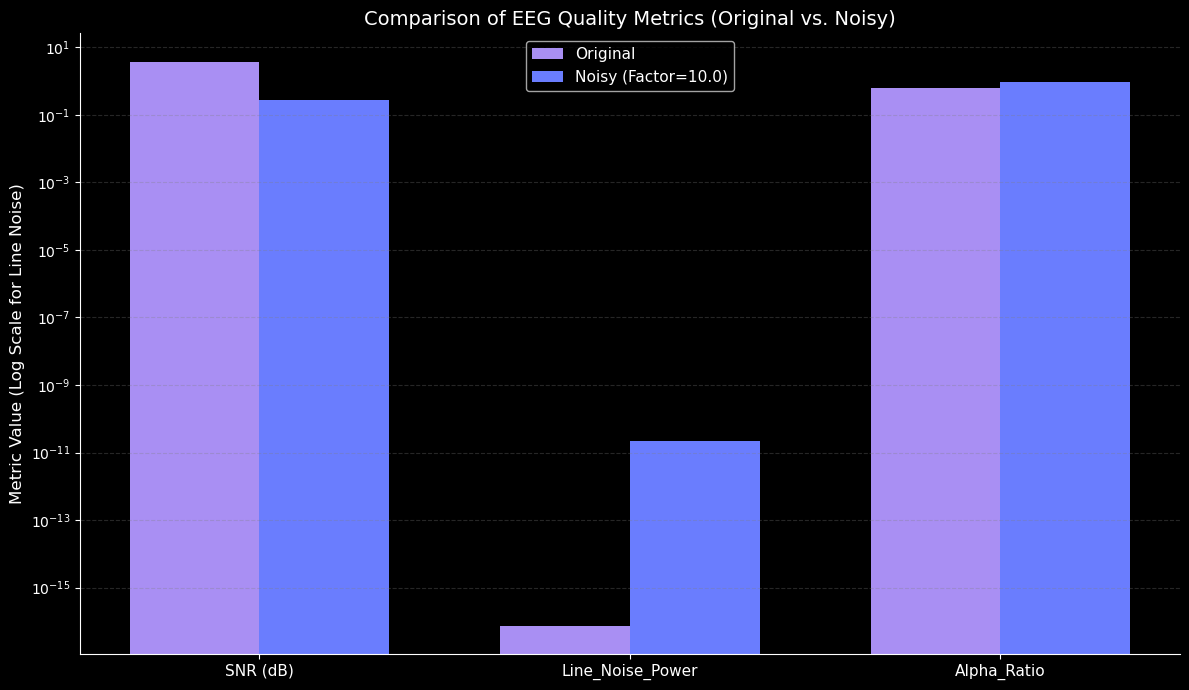

Comparison plot generated.


In [43]:
# --- Comparison Plot (Dark Style) ---
print("\nGenerating comparison plot (dark style)...")

plt.style.use('dark_background') # Apply dark theme

metrics = list(results_orig.keys())
labels = ['Original', 'Noisy']
orig_values = [results_orig.get(m, np.nan) for m in metrics]
noisy_values = [results_noisy.get(m, np.nan) for m in metrics]

# Handle potential NaN values gracefully for plotting
orig_values = [v if not np.isnan(v) else 0 for v in orig_values] # Replace NaN with 0 for plotting
noisy_values = [v if not np.isnan(v) else 0 for v in noisy_values]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Define colors inspired by the example
color_orig = '#a98ff3' # Light purple/pinkish
color_noisy = '#6a7dfe' # Light blue

fig, ax = plt.subplots(figsize=(12, 7)) # Slightly taller figure
rects1 = ax.bar(x - width/2, orig_values, width, label='Original', color=color_orig)
rects2 = ax.bar(x + width/2, noisy_values, width, label=f'Noisy (Factor={config["noise_level_factor"]})', color=color_noisy)

# Add some text for labels, title and axes ticks
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Comparison of EEG Quality Metrics (Original vs. Noisy)', fontsize=14)
ax.set_xticks(x)
# Clean up metric names for display
metric_labels = [m.replace('Average_', '').replace('_Proxy', '').replace('_dB', ' (dB)') for m in metrics]
ax.set_xticklabels(metric_labels, fontsize=11)
ax.legend(fontsize=11)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Use log scale for Line Noise Power due to very small values
log_applied = False
try:
    line_noise_index = metrics.index('Average_Line_Noise_Power_Proxy')
    lnp_orig = results_orig.get('Average_Line_Noise_Power_Proxy', np.nan)
    lnp_noisy = results_noisy.get('Average_Line_Noise_Power_Proxy', np.nan)
    if not np.isnan(lnp_orig) and not np.isnan(lnp_noisy) and lnp_orig > 0 and lnp_noisy > 0:
        # Check if values are significantly different before applying log scale
        if abs(lnp_orig - lnp_noisy) / max(lnp_orig, lnp_noisy, 1e-20) > 0.1: # Check relative difference
            ax.set_yscale('log', base=10)
            ax.set_ylabel('Metric Value (Log Scale for Line Noise)', fontsize=12)
            print("Note: Using log scale for Y-axis due to Line Noise Power values.")
            log_applied = True
        else:
            print("Note: Line Noise Power values are very similar; linear scale kept.")
    else:
         print("Note: Cannot use log scale for Line Noise Power (non-positive or NaN values).")
except Exception as e:
    print(f"Could not apply log scale: {e}") # Catch potential errors

# Remove bar labels
# ax.bar_label(rects1, padding=3, fmt='%.2e')
# ax.bar_label(rects2, padding=3, fmt='%.2e')

fig.tight_layout()
# Adjust grid lines for dark theme
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.3)
plt.show()

# Reset to default style if needed for subsequent plots in the notebook
# plt.style.use('default')

print("Comparison plot generated.")

## 7. Interpretation Guide

*   **Average_SNR_dB**: Higher values are better. Expect this to decrease significantly with added noise.
*   **Average_Line_Noise_Power_Proxy**: Lower values are better. Adding broadband noise might slightly increase the measured power in the line noise band, even though the noise isn't specifically line noise.
*   **Average_Alpha_Ratio_Proxy**: Values > 1 indicate stronger alpha during 'closed' proxy. Added noise will likely obscure the alpha rhythm, pushing this ratio closer to 1 or even below 1.

Compare the 'Original' and 'Noisy' bars in the plot above to see the impact of the added noise on each quality metric.

In [ ]:
print("\nNotebook execution finished.")